In [1]:
import random as rnd
import queue
import statistics as stat
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import random
import copy
import timeit
import csv
from bisect import insort

In [2]:
wait_Master = {'TP' : []}

for i in range(1, 4):
    global out
    myKeywMs = 'L' + str(i) #Lands Waits Master List
    wait_Master[myKeywMs] = []
    for j in range(1, 4): 
        myKey8 = 'A' + str(i) + str(j) #Attraction Waits Master List
        wait_Master[myKey8] = []   

In [85]:
# This program will simulate customers going through a Theme Park, with attractions for each land to be visited in a random manner.
# Future implementation is to implement ML techniques in choosing lands and attractions.

### PARAMETERS ###
param = {'_lambda':0.2, #Inter Arrival Time (IAT) in seconds (expovar)
         '_STsec': 0.25, #Security Check service time in seconds (expovar), twice the iat (for now, why?)
         '_TBA': 1/(10*60), #Time Between  Attractions (expovar), consider this as walking time
         '_TBL': 1/(15*60), #Time Between  lands (expovar), consider this as walking time
         'Tot_Sim_Time': 10*60*60, #Total time of simulation (in seconds)
         'TTC_TH': 1*60*60 #Time Til Close Threshold (in seconds)
        }

### STATE VARS ###
state_var = {'cust_in_TP': 0,
             'SBsec': False,
             'qsec': 0,
             'ID_list_LC':[]
            } #Number of customers currently in the theme park

### OUTVARS ###
out_var = {'Count_Arrival_Ev': 0,
           'TPA': [],
           'TPD': [],
           'sec_arr':[],
           'sec_dep': [],
           'First_land_choice':[]
          }

### ATTRIBUTES ###
cust_att= [] #Nested list denoting if customer has visited rides - ELABORATE?
attr = [] #All customer attributes shall be contained in this list, where their index is the ID
evList_ID = [] #All customer  events shall be contained here for reference

### SYSTEMIZING THE DEFINITION OF PARAMS, STATE_VARS, OUT_VARS AND CUST_ATT ###

LN = 3 #Number of lands in the Theme Park
AN = 3 #Number of attractions in each land

AC_param = [[220, 46, 30], [166, 47, 37], [140, 50, 40]]
ST_param = [[11, 3.25, 2.5], [20.75, 2, 2.75], [3.5, 2.5, 4.75]]

for i in range(1, LN+1):
    cust_att.append([False]*AN) #Create an attribute list template for customers arriving
    myKeyLandsArr = 'arrs_L' + str(i) #Record Arrival times in each land
    out_var[myKeyLandsArr] = []
    myKeyLandsDep = 'deps_L' + str(i) #Record Departure times in each land
    out_var[myKeyLandsDep] = []
    myKeyIDLs = 'ID_list_L' + str(i) #Record ID numbers of people in Land # (TEMPORARY, DO NOT USE FOR ANALYSIS, USE ARRS AND DEPS)
    state_var[myKeyIDLs] = []
    myKeyIDLs = 'custs_in_L' + str(i) #Record number of people in Land #
    state_var[myKeyIDLs] = 0
    myKeyIDACs = 'ID_list_AC' + str(i) #Record ID numbers of customers to be transferred to attraction choice func.
    state_var[myKeyIDACs] = []
    for j in range(1, AN+1):
        myKey1 = 'ST' + str(i) + str(j) #Service time for each attraction, arbitrary random times for now.
        param[myKey1] = ST_param[i-1][j-1]*60
        myKey2 = 'AC' + str(i) + str(j) #Attraction customer capacity,  arbitrary random numbers for now.
        param[myKey2] = AC_param[i-1][j-1]
        myKey3 = 'SB' + str(i) + str(j) #Server Busy state
        state_var[myKey3] = False
        myKey4 = 'q' + str(i) + str(j) #Queue length
        state_var[myKey4] = 0
        myKey7 = 'ID_list_A' + str(i) + str(j) #Queue length
        state_var[myKey7] = []
        myKey5 = 'arrs_A' + str(i) + str(j) #Arrival times for each attraction
        out_var[myKey5] = []
        myKey6 = 'deps_A' + str(i) + str(j) #Departure times for each attraction
        out_var[myKey6] = []      

### SAMPLE PATH (SP) ###
global SP
global SP1 #Queue Sample Path
global SP2 #Consistency, Atts
global SP3 #Consistency, Lands
SP = []
SP1 = []
SP2 = []
SP3 = []

In [86]:
# Define the global event list
evList = queue.PriorityQueue() #Try PriorityQueue? (no prioriy)

### Define the Event Generators ###

### ARRIVAL EVENT GENERATORS ###
def get_next_arrival_event_TP (clock, param):
    out_var['Count_Arrival_Ev'] += 1
    iat = rnd.expovariate(param['_lambda'])
    ev = (clock+iat, "Arrival to Theme Park", arrival_event_handler_TP)
    return ev    
    
def get_start_security_check_event (clock, param):
    ev = (clock, "Security Check 1 Start", security_check_event_handler)
    return ev

def get_land_choice (clock, param, cust_id): #For any customer id as an argument, add this customer Id to its corresponding event hanlder list as follows:
    state_var['ID_list_LC'].append(cust_id)
    # No expovar time, Expovar time only occurs after choice  is made.
    ev = (clock, "Land Choice for Customer#(" + str(cust_id)+")", land_choice_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

### Land 1 ###
def get_enter_land_1_event(clock, param, cust_id):
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBL' MINUTES WALK)
    st = rnd.expovariate(param['_TBL'])
    insort(state_var['ID_list_L1'], [(clock+st), cust_id])
    ev = (clock+st, "Customer Enters Land 1, #(" + str(cust_id)+")", land_1_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_att_1x_choice (clock, param, cust_id): #AC1 - Attraction Choice for land 1
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBA' MINUTES WALK)
    st = rnd.expovariate(param['_TBA'])
    insort(state_var['ID_list_AC1'], [(clock+st), cust_id])
    ev = (clock+st, "Attraction 1x Choice for Customer#(" + str(cust_id)+")", att_1x_choice_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_start_att_11_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 11, #(" + str(cust_id)+")", start_att_11_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_12_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 12, #(" + str(cust_id)+")", start_att_12_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_13_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 13, #(" + str(cust_id)+")", start_att_13_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

### Land 2 ###
def get_enter_land_2_event(clock, param, cust_id):
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBL' MINUTES WALK)
    st = rnd.expovariate(param['_TBL'])
    insort(state_var['ID_list_L2'], [(clock+st), cust_id])
    ev = (clock+st, "Customer Enters Land 2, #(" + str(cust_id)+")", land_2_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_att_2x_choice (clock, param, cust_id): #AC2 - Attraction Choice for land 2
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBA' MINUTES WALK)
    st = rnd.expovariate(param['_TBA'])
    insort(state_var['ID_list_AC2'], [(clock+st), cust_id])
    ev = (clock+st, "Attraction 2x Choice for Customer#(" + str(cust_id)+")", att_2x_choice_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_start_att_21_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 21, #(" + str(cust_id)+")", start_att_21_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_22_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 22, #(" + str(cust_id)+")", start_att_22_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_23_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 23, #(" + str(cust_id)+")", start_att_23_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

### Land 3 ###
def get_enter_land_3_event(clock, param, cust_id):
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBL' MINUTES WALK)
    st = rnd.expovariate(param['_TBL'])
    insort(state_var['ID_list_L3'], [(clock+st), cust_id])
    ev = (clock+st, "Customer Enters Land 3, #(" + str(cust_id)+")", land_3_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_att_3x_choice (clock, param, cust_id): #AC3 - Attraction Choice for land 3
    # EXPOVARIATE RANDOM TIME (AVERAGE OF '_TBA' MINUTES WALK)
    st = rnd.expovariate(param['_TBA'])
    insort(state_var['ID_list_AC3'], [(clock+st), cust_id])
    ev = (clock+st, "Attraction 3x Choice for Customer#(" + str(cust_id)+")", att_3x_choice_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_start_att_31_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 31, #(" + str(cust_id)+")", start_att_31_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_32_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 32, #(" + str(cust_id)+")", start_att_32_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)

def get_start_att_33_event(clock, param, cust_id):
    ev = (clock, "Customer Enters Attraction 33, #(" + str(cust_id)+")", start_att_33_event_handler)
    evList_ID[cust_id].append(ev[1])
    return(ev)


### DEPRTURE EVENT GENERATORS ###
def get_next_departure_event_security_check (clock, param):
    st = rnd.expovariate(param['_STsec'])
    ev = (clock+st, "Security Check 1 End", departure_event_handler_security_check)
    return ev

### Land 1 ###
def get_exit_land_1_event(clock, param, cust_id):
    ev = (clock, "Customer Exits Land 1, #(" + str(cust_id)+")", land_1_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_depart_att_11_event(clock, param):
    st = param['ST11']
    ev = (clock+st, "Customers Leaving Attraction 11", depart_att_11_event_handler)
    return(ev)

def get_depart_att_12_event(clock, param):
    st = param['ST12']
    ev = (clock+st, "Customers Leaving Attraction 12", depart_att_12_event_handler)
    return(ev)

def get_depart_att_13_event(clock, param):
    st = param['ST13']
    ev = (clock+st, "Customers Leaving Attraction 13", depart_att_13_event_handler)
    return(ev)

### Land 2 ###
def get_exit_land_2_event(clock, param, cust_id):
    ev = (clock, "Customer Exits Land 2, #(" + str(cust_id)+")", land_2_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_depart_att_21_event(clock, param):
    st = param['ST21']
    ev = (clock+st, "Customers Leaving Attraction 21", depart_att_21_event_handler)
    return(ev)

def get_depart_att_22_event(clock, param):
    st = param['ST22']
    ev = (clock+st, "Customers Leaving Attraction 22", depart_att_22_event_handler)
    return(ev)

def get_depart_att_23_event(clock, param):
    st = param['ST23']
    ev = (clock+st, "Customers Leaving Attraction 23", depart_att_23_event_handler)
    return(ev)

### Land 3 ###
def get_exit_land_3_event(clock, param, cust_id):
    ev = (clock, "Customer Exits Land 3, #(" + str(cust_id)+")", land_3_arr_event_handler)
    evList_ID[cust_id].append(ev[1])
    return ev

def get_depart_att_31_event(clock, param):
    st = param['ST31']
    ev = (clock+st, "Customers Leaving Attraction 31", depart_att_31_event_handler)
    return(ev)

def get_depart_att_32_event(clock, param):
    st = param['ST32']
    ev = (clock+st, "Customers Leaving Attraction 32", depart_att_32_event_handler)
    return(ev)

def get_depart_att_33_event(clock, param):
    st = param['ST33']
    ev = (clock+st, "Customers Leaving Attraction 33", depart_att_33_event_handler)
    return(ev)

### Theme Park Departure ###
def get_next_departure_event_TP (clock, param, cust_id):
    out_var['TPD'].append([clock, cust_id])
    ev = (clock, "Departure from Theme Park, #(" + str(cust_id)+")", departure_event_handler_TP)
    evList_ID[cust_id].append(ev[1])
    return ev


In [87]:
# Define Event handlers

# ARRIVALS ___________________
def arrival_event_handler_TP (clock, state_var, out_var, param, att): # Commented lines are for future use
    if (True):   # Check if time til close is greater than threshold
        state_var['cust_in_TP'] += 1                # Increase number of customers in theme park
        out_var['TPA'].append(clock)                # Record arrival time to Theme park        
        state_var['qsec'] += 1                # Essentially, make customer enter queue 1
        if (state_var['SBsec'] == False) and (state_var['qsec'] >= 1): #If conditions are satisfied, start security check
            schedule_event(get_start_security_check_event(clock, param))        
    if (param['Tot_Sim_Time']-clock) > param['TTC_TH']: #Check if time til close is greater than threshold
        schedule_event(get_next_arrival_event_TP(clock, param)) #Generate New Arrival to keep program running

def security_check_event_handler (clock, state_var, out_var, param, att):
    state_var['SBsec'] = True #Make the security guard busy
    state_var['qsec'] -= 1    #Remove person doing the security check from queue
    out_var['sec_arr'].append(clock)
    schedule_event(get_next_departure_event_security_check(clock, param))
    
def land_choice_event_handler (clock, state_var, out_var, param, att):
    cust_id = state_var['ID_list_LC'].pop(0)
    land_options = [] #Initialize land options, ie. lands customer can visit
    for land_index in range(0, LN):
        first_element = attr[cust_id][land_index][0] #Grab first attraction state
        for state in attr[cust_id][land_index]:
            if (first_element != state):
                raise Exception("Customer (" + str(cust_id) + ") has not visited all rides") #Remove in next revision
        land_options.append(not(first_element)) #append the negation of of ride, as in, if customer visited attractions in land 1, it is not availabe as an option
    choice_list = [] #Initialize choice list, this list contains only the land numbers that are permitted to be entered
    for i in range(len(land_options)):
        if land_options[i]: #If land is availabe, ie. true
            choice_list.append(i+1) #append land number in choice list from land options list
    if (len(choice_list) == 0) :
        schedule_event(get_next_departure_event_TP(clock, param, cust_id))
    else:
        final_choice = random.choice(choice_list) # Use NN to choose least wait
        if final_choice == 1:
            schedule_event(get_enter_land_1_event(clock, param, cust_id))
        if final_choice == 2:
            schedule_event(get_enter_land_2_event(clock, param, cust_id))
        if final_choice == 3:
            schedule_event(get_enter_land_3_event(clock, param, cust_id))
        

### LAND 1 ARRIVAL EVENT HANDLERS ###            
def land_1_arr_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_L1'].pop(0))[1]  #Best I could do, hope 'insort' does the job correctly
    out_var['arrs_L1'].append([clock, cust_id, state_var['custs_in_L1']])
    state_var['custs_in_L1'] += 1    #DEPENDANT ON ABOVE!
    schedule_event(get_att_1x_choice(clock, param, cust_id))
        
def att_1x_choice_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_AC1'].pop(0))[1] #Best I could do, hope 'insort' does the job correctly
    att_options = [] #Initialize attraction options, ie. attractions customer can visit
    choice_list = [] #Initialize choice list, this list contains only the attraction numbers that are permitted to be entered
    for att_index in range(0, AN):
        att_options.append(not(attr[cust_id][0][att_index])) #append the negation of attraction, as in, if customer visited attraction already, it is not availabe as an option
    for i in range(len(att_options)):
        if att_options[i]: #If land is availabe, ie. true
            choice_list.append(i+1) #append land number in choice list from land options list
    if len(choice_list) == 0:
        out_var['deps_L1'].append([clock, cust_id])
        state_var['custs_in_L1'] -= 1
        schedule_event(get_land_choice(clock, param, cust_id)) #get_land_choice is equivalent to exit land 
    else:
        final_choice = random.choice(choice_list)
        if final_choice == 1:
            out_var['arrs_A11'].append([clock, cust_id, state_var['q11']])
            state_var['q11'] +=1
            state_var['ID_list_A11'].append(cust_id)
            schedule_event(get_start_att_11_event(clock, param, cust_id))
        if final_choice == 2:
            out_var['arrs_A12'].append([clock, cust_id, state_var['q12']])
            state_var['q12'] +=1
            state_var['ID_list_A12'].append(cust_id)
            schedule_event(get_start_att_12_event(clock, param, cust_id))
        if final_choice == 3:
            out_var['arrs_A13'].append([clock, cust_id, state_var['q13']])
            state_var['q13'] +=1
            state_var['ID_list_A13'].append(cust_id)
            schedule_event(get_start_att_13_event(clock, param, cust_id))

def start_att_11_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q11'] >= param['AC11'] and state_var['SB11'] == False):
        state_var['SB11'] = True
        state_var['q11'] -= param['AC11']
        schedule_event(get_depart_att_11_event(clock, param))
        
def start_att_12_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q12'] >= param['AC12'] and state_var['SB12'] == False):
        state_var['SB12'] = True
        state_var['q12'] -= param['AC12']
        schedule_event(get_depart_att_12_event(clock, param))

def start_att_13_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q13'] >= param['AC13'] and state_var['SB13'] == False):
        state_var['SB13'] = True
        state_var['q13'] -= param['AC13']
        schedule_event(get_depart_att_13_event(clock, param))
        
        
### LAND 2 ARRIVAL EVENT HANDLERS ###            
def land_2_arr_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_L2'].pop(0))[1]     #insort
    out_var['arrs_L2'].append([clock, cust_id, state_var['custs_in_L1']])
    state_var['custs_in_L2'] += 1                 #DEPENDANT ON ABOVE!
    schedule_event(get_att_2x_choice(clock, param, cust_id))
        
def att_2x_choice_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_AC2'].pop(0))[1]
    att_options = [] #Initialize attraction options, ie. attractions customer can visit
    choice_list = [] #Initialize choice list, this list contains only the attraction numbers that are permitted to be entered
    for att_index in range(0, AN):
        att_options.append(not(attr[cust_id][1][att_index])) #append the negation of attraction, as in, if customer visited attraction already, it is not availabe as an option
    for i in range(len(att_options)):
        if att_options[i]: #If land is availabe, ie. true
            choice_list.append(i+1) #append land number in choice list from land options list
    if len(choice_list) == 0:
        out_var['deps_L2'].append([clock, cust_id])
        state_var['custs_in_L2'] -= 1
        schedule_event(get_land_choice(clock, param, cust_id)) #get_land_choice is equivalent to exit land 
    else:
        final_choice = random.choice(choice_list) # (clock, param, state_var, choice_list, 2)
        if final_choice == 1:
            out_var['arrs_A21'].append([clock, cust_id, state_var['q21']])
            state_var['q21'] +=1
            state_var['ID_list_A21'].append(cust_id)
            schedule_event(get_start_att_21_event(clock, param, cust_id))
        if final_choice == 2:
            out_var['arrs_A22'].append([clock, cust_id, state_var['q22']])
            state_var['q22'] +=1
            state_var['ID_list_A22'].append(cust_id)
            schedule_event(get_start_att_22_event(clock, param, cust_id))
        if final_choice == 3:
            out_var['arrs_A23'].append([clock, cust_id, state_var['q23']])
            state_var['q23'] +=1
            state_var['ID_list_A23'].append(cust_id)
            schedule_event(get_start_att_23_event(clock, param, cust_id))

def start_att_21_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q21'] >= param['AC21'] and state_var['SB21'] == False):
        state_var['SB21'] = True
        state_var['q21'] -= param['AC21']
        schedule_event(get_depart_att_21_event(clock, param))
        
def start_att_22_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q22'] >= param['AC22'] and state_var['SB22'] == False):
        state_var['SB22'] = True
        state_var['q22'] -= param['AC22']
        schedule_event(get_depart_att_22_event(clock, param))

def start_att_23_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q23'] >= param['AC23'] and state_var['SB23'] == False):
        state_var['SB23'] = True
        state_var['q23'] -= param['AC23']
        schedule_event(get_depart_att_23_event(clock, param))
        
### LAND 3 ARRIVAL EVENT HANDLERS ###            
def land_3_arr_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_L3'].pop(0))[1]  #insort
    out_var['arrs_L3'].append([clock, cust_id, state_var['custs_in_L1']])
    state_var['custs_in_L3'] += 1              #DEPENDANT ON ABOVE!
    schedule_event(get_att_3x_choice(clock, param, cust_id))
        
def att_3x_choice_event_handler (clock, state_var, out_var, param, att):
    cust_id = (state_var['ID_list_AC3'].pop(0))[1]
    att_options = [] #Initialize attraction options, ie. attractions customer can visit
    choice_list = [] #Initialize choice list, this list contains only the attraction numbers that are permitted to be entered
    for att_index in range(0, AN):
        att_options.append(not(attr[cust_id][2][att_index])) #append the negation of attraction, as in, if customer visited attraction already, it is not availabe as an option
    for i in range(len(att_options)):
        if att_options[i]: #If land is availabe, ie. true
            choice_list.append(i+1) #append land number in choice list from land options list
    if len(choice_list) == 0:
        out_var['deps_L3'].append([clock, cust_id])
        state_var['custs_in_L3'] -= 1
        schedule_event(get_land_choice(clock, param, cust_id)) #get_land_choice is equivalent to exit land 
    else:
        final_choice = random.choice(choice_list) #NN_AC_Least_Wait (clock, param, state_var, choice_list, 3)
        if final_choice == 1:
            out_var['arrs_A31'].append([clock, cust_id, state_var['q31']])
            state_var['q31'] +=1
            state_var['ID_list_A31'].append(cust_id)
            schedule_event(get_start_att_31_event(clock, param, cust_id))
        if final_choice == 2:
            out_var['arrs_A32'].append([clock, cust_id, state_var['q32']])
            state_var['q32'] +=1
            state_var['ID_list_A32'].append(cust_id)
            schedule_event(get_start_att_32_event(clock, param, cust_id))
        if final_choice == 3:
            out_var['arrs_A33'].append([clock, cust_id, state_var['q33']])
            state_var['q33'] +=1
            state_var['ID_list_A33'].append(cust_id)
            schedule_event(get_start_att_33_event(clock, param, cust_id))

def start_att_31_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q31'] >= param['AC31'] and state_var['SB31'] == False):
        state_var['SB31'] = True
        state_var['q31'] -= param['AC31']
        schedule_event(get_depart_att_31_event(clock, param))
        
def start_att_32_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q32'] >= param['AC32'] and state_var['SB32'] == False):
        state_var['SB32'] = True
        state_var['q32'] -= param['AC32']
        schedule_event(get_depart_att_32_event(clock, param))

def start_att_33_event_handler (clock, state_var, out_var, param, att):
    if (state_var['q33'] >= param['AC33'] and state_var['SB33'] == False):
        state_var['SB33'] = True
        state_var['q33'] -= param['AC33']
        schedule_event(get_depart_att_33_event(clock, param))
    

# DEPARTURES ___________________
def departure_event_handler_security_check (clock, state_var, out_var, param, att):
    state_var['SBsec'] = False # Make the ride free
    #CHECK OUTVARS FOR ARRIVALS, AND DEPS
    out_var['sec_dep'].append(clock)
    if state_var['qsec'] >= 1:
        schedule_event(get_start_security_check_event(clock, param))
    ### ASSIGN AN ATTRIBUTE LIST FOR CUSTOMERS LEAVING THE SECURITY GATE, AND ADD CHOICE FUNCTION TO CHOOSE WHICH LAND CUSTOMER IS GOING TO NEXT ###
    ### ID ASSIGNMENT OF CUSTOMERS IS DONE AFTER SECURITY GATE
    # Above comments can be neglected for the time being #
    attr.append(copy.deepcopy(cust_att))
    evList_ID.append(['Create instance'])
    schedule_event(get_land_choice(clock, param, len(attr)-1)) # "len(attr)-1" IS THE ID NUMBER OF CUSTOMER

### LAND 1 DEPARTURE EVENT HANDLERS ###
def depart_att_11_event_handler (clock, state_var, out_var, param, att):
    state_var['SB11'] = False # Make the ride free
    for i in range (0, param['AC11']):
        cust_id = state_var['ID_list_A11'].pop(0)
        attr[cust_id][0][0]=True
        out_var['deps_A11'].append([clock, cust_id])
        schedule_event(get_att_1x_choice(clock, param, cust_id))
    if (state_var['q11'] >= param['AC11'] and state_var['SB11'] == False):
        schedule_event(get_start_att_11_event(clock, param, cust_id))
        
def depart_att_12_event_handler (clock, state_var, out_var, param, att):
    state_var['SB12'] = False # Make the ride free
    for i in range (0, param['AC12']):
        cust_id = state_var['ID_list_A12'].pop(0)
        attr[cust_id][0][1]=True
        out_var['deps_A12'].append([clock, cust_id])
        schedule_event(get_att_1x_choice(clock, param, cust_id))
    if (state_var['q12'] >= param['AC12'] and state_var['SB12'] == False):
        schedule_event(get_start_att_12_event(clock, param, cust_id))
        
def depart_att_13_event_handler (clock, state_var, out_var, param, att):
    state_var['SB13'] = False # Make the ride free
    for i in range (0, param['AC13']):
        cust_id = state_var['ID_list_A13'].pop(0)
        attr[cust_id][0][2]=True
        out_var['deps_A13'].append([clock, cust_id])
        schedule_event(get_att_1x_choice(clock, param, cust_id))
    if (state_var['q13'] >= param['AC13'] and state_var['SB13'] == False):
        schedule_event(get_start_att_13_event(clock, param, cust_id))
        
### LAND 2 DEPARTURE EVENT HANDLERS ###
def depart_att_21_event_handler (clock, state_var, out_var, param, att):
    state_var['SB21'] = False # Make the ride free
    for i in range (0, param['AC21']):
        cust_id = state_var['ID_list_A21'].pop(0)
        attr[cust_id][1][0]=True
        out_var['deps_A21'].append([clock, cust_id])
        schedule_event(get_att_2x_choice(clock, param, cust_id))
    if (state_var['q21'] >= param['AC21'] and state_var['SB21'] == False):
        schedule_event(get_start_att_21_event(clock, param, cust_id))
        
def depart_att_22_event_handler (clock, state_var, out_var, param, att):
    state_var['SB22'] = False # Make the ride free
    for i in range (0, param['AC22']):
        cust_id = state_var['ID_list_A22'].pop(0)
        attr[cust_id][1][1]=True
        out_var['deps_A22'].append([clock, cust_id])
        schedule_event(get_att_2x_choice(clock, param, cust_id))
    if (state_var['q22'] >= param['AC22'] and state_var['SB22'] == False):
        schedule_event(get_start_att_22_event(clock, param, cust_id))
        
def depart_att_23_event_handler (clock, state_var, out_var, param, att):
    state_var['SB23'] = False # Make the ride free
    for i in range (0, param['AC23']):
        cust_id = state_var['ID_list_A23'].pop(0)
        attr[cust_id][1][2]=True
        out_var['deps_A23'].append([clock, cust_id])
        schedule_event(get_att_2x_choice(clock, param, cust_id))
    if (state_var['q23'] >= param['AC23'] and state_var['SB23'] == False):
        schedule_event(get_start_att_23_event(clock, param, cust_id))
        
### LAND 3 DEPARTURE EVENT HANDLERS ###
def depart_att_31_event_handler (clock, state_var, out_var, param, att):
    state_var['SB31'] = False # Make the ride free
    for i in range (0, param['AC31']):
        cust_id = state_var['ID_list_A31'].pop(0)
        attr[cust_id][2][0]=True
        out_var['deps_A31'].append([clock, cust_id])
        schedule_event(get_att_3x_choice(clock, param, cust_id))
    if (state_var['q31'] >= param['AC31'] and state_var['SB31'] == False):
        schedule_event(get_start_att_31_event(clock, param, cust_id))
        
def depart_att_32_event_handler (clock, state_var, out_var, param, att):
    state_var['SB32'] = False # Make the ride free
    for i in range (0, param['AC32']):
        cust_id = state_var['ID_list_A32'].pop(0)
        attr[cust_id][2][1]=True
        out_var['deps_A32'].append([clock, cust_id])
        schedule_event(get_att_3x_choice(clock, param, cust_id))
    if (state_var['q32'] >= param['AC32'] and state_var['SB32'] == False):
        schedule_event(get_start_att_32_event(clock, param, cust_id))
        
def depart_att_33_event_handler (clock, state_var, out_var, param, att):
    state_var['SB33'] = False # Make the ride free
    for i in range (0, param['AC33']):
        cust_id = state_var['ID_list_A33'].pop(0)
        attr[cust_id][2][2]=True
        out_var['deps_A33'].append([clock, cust_id])
        schedule_event(get_att_3x_choice(clock, param, cust_id))
    if (state_var['q33'] >= param['AC33'] and state_var['SB33'] == False):
        schedule_event(get_start_att_23_event(clock, param, cust_id))
        
def departure_event_handler_TP (clock, state_var, out_var, param, att):
    state_var['cust_in_TP'] -= 1 

In [88]:
#Functions below are used for Analysis and debugging
def vectorize_list(nl, i): #Function which takes in a nested list, and outputs a vector given the index
    outvec = []
    for instance in nl:
        outvec.append(instance[i])
    return outvec

def CheckConsistency (state_var, param): # Checks if state variables are consistent, used for debugging
    isconsistent = state_var['cust_in_TP'] - len(state_var['ID_list_L1'])- len(state_var['ID_list_L2']) - len(state_var['ID_list_L3'])
    if isconsistent == 0:
        return True
    else:
        return False
    
def Qs (state_var, param):
    qs = []
    for i in range(1, LN+1):
        for j in range(1, AN+1):
            xx = str(i) + str(j)
            qk = 'q'+xx
            ack = 'AC'+xx
            qtemp = state_var[qk]/param[ack]
            qs.append(round(qtemp,2))
    return qs

In [89]:
# Insert an event into the event list		
def schedule_event(ev):
    global evList
    evList.put(ev)

# Main simulation function
def sim(state_var, out_var, param):
    clock = 0
    # Initialize (seed) the RNG	
    rnd.seed()
    # Insert initial event
    ev = get_next_arrival_event_TP(clock, param)
    schedule_event(ev)
    # Start simulation
    global evCount
    evCount = 0
    while (not(evList.empty())) and (clock < param['Tot_Sim_Time']):
        ev = evList.get()
        clock = ev[0] #Update time
        ev[2](clock, state_var, out_var, param, attr)
        evCount += 1
        if len(SP) == 0:
            Qstemp = Qs (state_var, param)
            SP.append([len(SP), round(clock,2),ev[1], Qstemp[0], Qstemp[1], Qstemp[2], Qstemp[3], Qstemp[4], Qstemp[5], Qstemp[6], Qstemp[7], Qstemp[8]])
        elif Qstemp != Qs (state_var, param):
            Qstemp = Qs (state_var, param)
            SP.append([len(SP), round(clock,2),ev[1], Qstemp[0], Qstemp[1], Qstemp[2], Qstemp[3], Qstemp[4], Qstemp[5], Qstemp[6], Qstemp[7], Qstemp[8]]) 

def main():
        global out_var
        rnd.seed() # Reseed RNG (If multiple runs, remove (mySeed))
        start = timeit.default_timer() #Start timing simulation run
        sim(state_var, out_var, param)
        stop = timeit.default_timer() #End timing
        print('Sim Time: ', round(stop - start, 2), 'seconds') 

if __name__ == '__main__':
    main()

Sim Time:  5.58 seconds


In [90]:
for instance in out_var['TPD']:
    i = instance[1]
    wait_Master['TP'].append((instance[0]-out_var['TPA'][i])/60)  # Index#, ID#, time in TP, Time of departure

In [91]:
def calc_wait (arrs, deps, ST):
    Axxw = []
    for i in range(len(deps)):
        idnum = deps[i][1]
        if idnum != arrs[i][1]:
            raise Exception("Non-matching ID")
        q = arrs[i][2]
        wt = deps[i][0]-arrs[i][0]-ST #Remove service time to denote actual wait time, since ST is constant
        time = arrs[i][0]/60
        Axxw.append([i, idnum, q, wt/60, time])
    return Axxw

def calc_wait_L (arrs, deps):
    Axxw = []
    index = 0
    for i in range(len(deps)):
        idnum = deps[i][1]
        for j in range(len(arrs)): #Nested loop, could cost computation, a better way is to sort arrs and deps
            if arrs[j][1] ==  idnum:
                aj = j
                break

        if deps[i][1] != arrs[aj][1]:
            raise Exception("Non-matching ID")
        q = arrs[aj][2]
        wt = deps[i][0]-arrs[aj][0]
        time = arrs[aj][0]/60
        Axxw.append([i, idnum, q, wt/60, time])
        index += 1
    return Axxw

In [92]:
print('out_var[\'Times_in_TP\'] has already been created (Index#, ID#, time in TP)')
print('All times  are in minutes')
#Calculate wait_times for each attractions
for i in range(1, LN+1):
    Lx = 'L'+str(i)
    wait_key = 'wait_' + Lx # Wait  times for each attraction.
    arrs_key = 'arrs_' + Lx
    deps_key = 'deps_' + Lx
    arrs = out_var[arrs_key]
    deps = out_var[deps_key]
    out_var[wait_key] = calc_wait_L(arrs, deps)
    print('out_var[\'' + wait_key + '\'] created. (Index#, ID#, custs in land, wait time, time of arrival)' )
    for j in range(1, AN+1):
        Axx = 'A'+str(i)+str(j)
        wait_key = 'wait_' + Axx # Wait  times for each attraction.
        arrs_key = 'arrs_' + Axx
        deps_key = 'deps_' + Axx
        arrs = out_var[arrs_key]
        deps = out_var[deps_key]
        ST = ST_param[i-1][j-1]
        out_var[wait_key] = calc_wait(arrs, deps, ST)
        print('out_var[\'' + wait_key + '\'] created. (Index#, ID#, queue at entry, wait time, time of arrival)' )

out_var['Times_in_TP'] has already been created (Index#, ID#, time in TP)
All times  are in minutes
out_var['wait_L1'] created. (Index#, ID#, custs in land, wait time, time of arrival)
out_var['wait_A11'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_A12'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_A13'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_L2'] created. (Index#, ID#, custs in land, wait time, time of arrival)
out_var['wait_A21'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_A22'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_A23'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_L3'] created. (Index#, ID#, custs in land, wait time, time of arrival)
out_var['wait_A31'] created. (Index#, ID#, queue at entry, wait time, time of arrival)
out_var['wait_A32'] created. (Index#

In [93]:
for i in range(1, LN+1):
    Lx = 'L'+str(i)
    for instance in out_var['wait_'+Lx]:
        wait_Master[Lx].append(instance[3])
    for j in range(1, AN+1):
        Axx = 'A'+str(i)+str(j)
        for instance_A in out_var['wait_'+Axx]:
            wait_Master[Axx].append(instance_A[3])

In [94]:
def hist_waits (Lax):
    plt.hist(wait_Master[Lax], color = 'blue', edgecolor = 'black', bins = 30)
    plt.title('Histogram of Wait - Delay in ' + Lax)
    plt.xlabel('Delay (min)')
    plt.ylabel('Number of Instances')
    print('mean = ',stat.mean(wait_Master[Lax]))
    print('stdev = ',stat.stdev(wait_Master[Lax]))
    plt.show()
    if Lax[0] == 'A':
        xx = Lax[1]+Lax[2]
        stkey = 'ST'+str(xx)
        ackey = 'AC'+str(xx)
        print('ST', '->', param[stkey], 'seconds')
        print('AC', '->', param[ackey])
    print('--------------------------------------')

mean =  316.25554479451654
stdev =  58.07121176855024


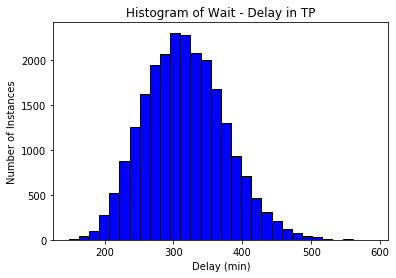

--------------------------------------
mean =  73.44425988116865
stdev =  22.52524102688225


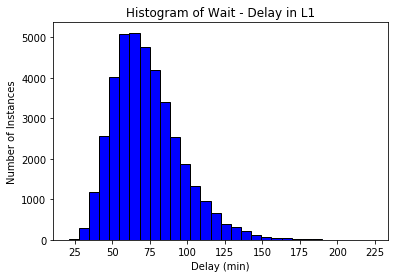

--------------------------------------
mean =  23.533307289431114
stdev =  9.829759319740818


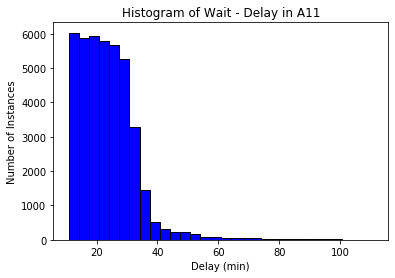

ST -> 660 seconds
AC -> 220
--------------------------------------
mean =  5.999716433002959
stdev =  3.078441241660058


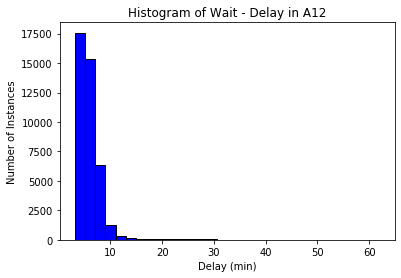

ST -> 195.0 seconds
AC -> 46
--------------------------------------
mean =  4.531615499498195
stdev =  2.107687281380217


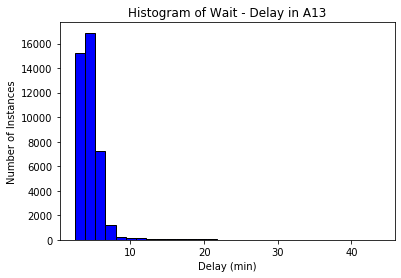

ST -> 150.0 seconds
AC -> 30
--------------------------------------
mean =  122.18974873158635
stdev =  39.23968410174204


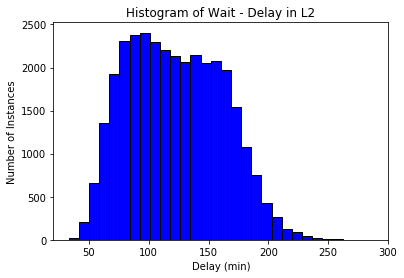

--------------------------------------
mean =  75.91475946929896
stdev =  36.283971279242685


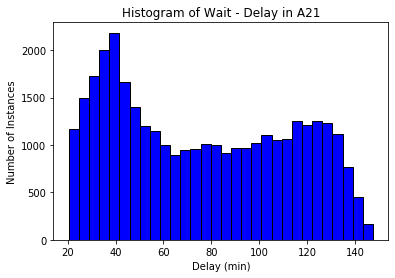

ST -> 1245.0 seconds
AC -> 166
--------------------------------------
mean =  4.887447364260533
stdev =  3.1533173760444377


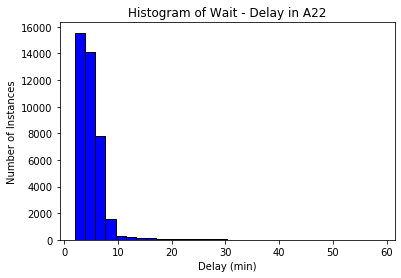

ST -> 120 seconds
AC -> 47
--------------------------------------
mean =  5.025410419553396
stdev =  2.484193505405224


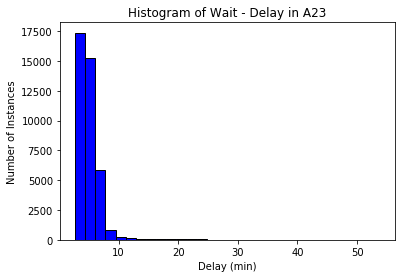

ST -> 165.0 seconds
AC -> 37
--------------------------------------
mean =  101.23954927408352
stdev =  35.164185072482404


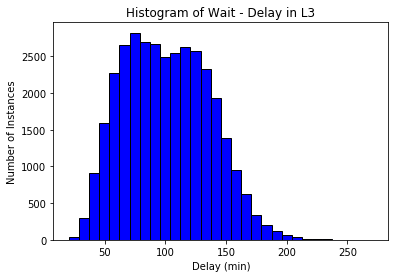

--------------------------------------
mean =  11.97655875558758
stdev =  6.7461751608958735


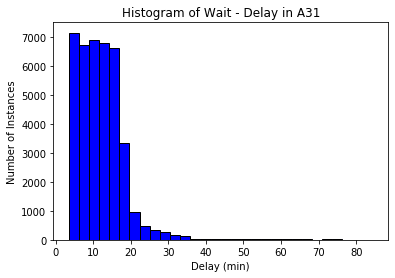

ST -> 210.0 seconds
AC -> 140
--------------------------------------
mean =  5.590662007527767
stdev =  3.2612472270665034


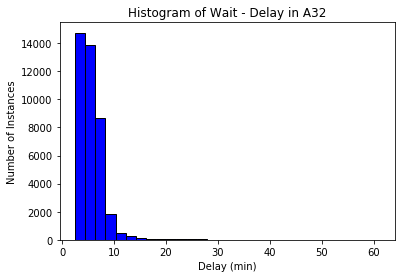

ST -> 150.0 seconds
AC -> 50
--------------------------------------
mean =  47.37939571526104
stdev =  31.773462737257205


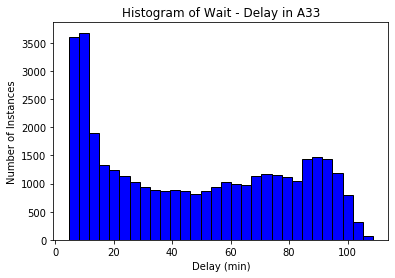

ST -> 285.0 seconds
AC -> 40
--------------------------------------


In [95]:
for key in wait_Master:
    hist_waits(key)

# Performance Metrics
## 1) Queue Density

In [96]:
def vectorize_list(nl, i): #Function which takes in a nested list, and outputs a vector given the index
    outvec = []
    for instance in nl:
        outvec.append(instance[i])
    return outvec

In [97]:
def plot_q_density_combined(SP):
    global q_density
    q_density = {}
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'lime', 'orange', 'k']
    plt.title('Q Density at each ride')
    plt.xlabel('Time (Hour)')
    plt.ylabel('Q/AC')
    time_list = vectorize_list(SP, 1)
    time_list_min = [x / 3600 for x in time_list]
    for i in range(1, LN+1):
        for j in range(1, AN+1):
            index = (i-1)*(LN) + j
            Axx = 'A'+str(i)+str(j)
            q_density[Axx] = vectorize_list(SP, 2+index)
            plt.plot(time_list_min, q_density[Axx], color = color[index-1])
            print(color[index-1], '->', Axx)

b -> A11
g -> A12
r -> A13
c -> A21
m -> A22
y -> A23
lime -> A31
orange -> A32
k -> A33


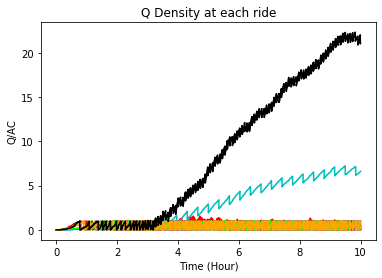

In [98]:
plot_q_density_combined(SP)

### As apparent from the graphs above, we see that A33 has the most increase in queue density, where the queue reached approximately 25 times the attraction capacity! A21 also has a high queue density of approximately 7.

In [99]:
def plot_q_density_perride(Axx, color = 'b'):
    plt.title('Q Density at ' + Axx)
    plt.xlabel('Time (Hour)')
    plt.ylabel('Q/AC')
    time_list = vectorize_list(SP, 1)
    time_list_hr = [x / 3600 for x in time_list]
    plt.plot(time_list_hr, q_density[Axx], color)
    plt.show()

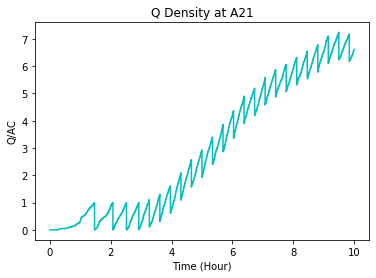

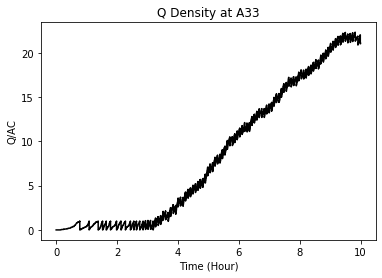

In [102]:
plot_q_density_perride('A21', 'c')
plot_q_density_perride('A33', 'k')

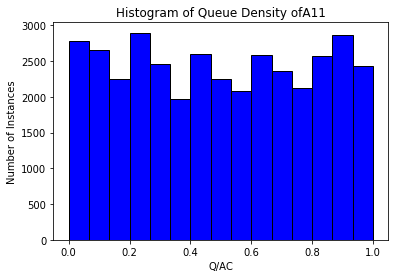

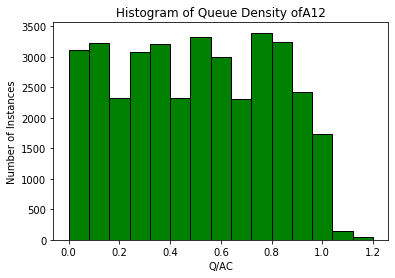

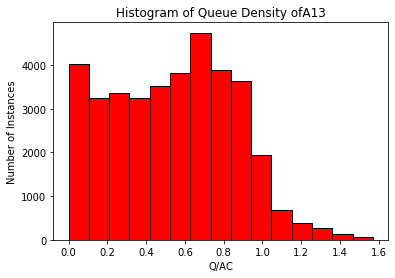

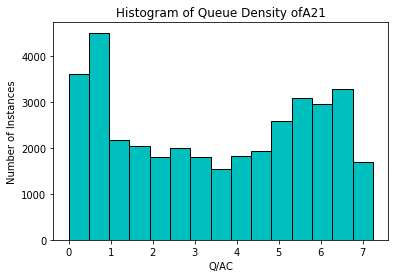

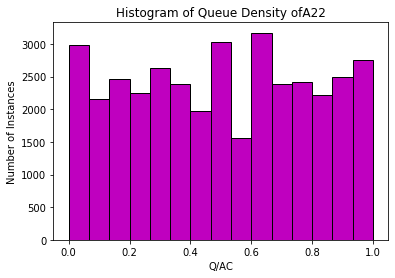

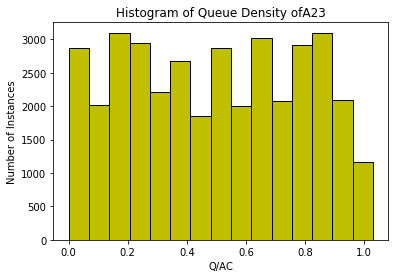

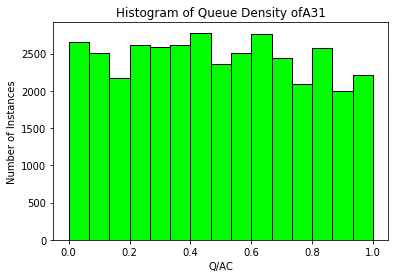

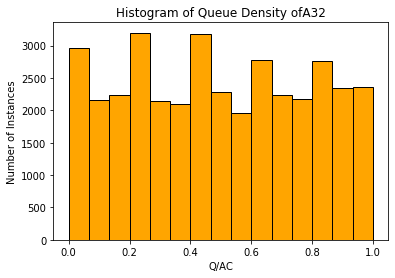

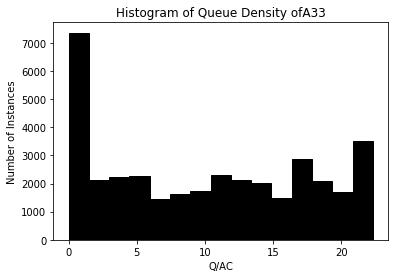

In [101]:
i=0
for key in q_density:
    plt.hist(q_density[key], color = color[i], edgecolor = 'black', bins = 15)
    plt.title('Histogram of Queue Density of' + str(key))
    plt.xlabel('Q/AC')
    plt.ylabel('Number of Instances')
    plt.show()
    i = i+1

### Proposal to rectify the issue: Try to equally distribute customers such that the queue density of each ride is equivalent. Technical details are to be thoroughly explained in next revision.

### Due to time constraint, the simulation abruptly ends after simulation time exceeds the input  parameter 'Tot_Sim_Time'. Impure data includes people inside the theme park, considering all of them leaving at the moment the simulation ends, which is not an accurate representation.

### Next revision (if time permits) shall be to arrange a proper exit for these customers inside the park. Technical details shall be thoroughly explained.

### Now, we shall try a Deep Learning algorithm instead of simple linear regression for predicting the wait time. Neural Networks are superior to Linear Regression prediction algorithm for a plethora  of reasons, but the main reason we have chosen a Deep Neural Network is the fact that a NN can improve (learn) from new data, unlike linear regression, where the data has to be supplied all at once.

In [ ]:
# INCLUDE THE IDs in your time analysis for more accurate results.
# I.E. Times_in_park is a nested list of time of customer in TP, and their respective ID number.
# ID NUMBER INCLUDED ONLY FOR

In [ ]:
def calc_wait (arrs, deps, ST):
    Axxw = []
    for i in range(len(deps)):
        idnum = deps[i][1]
        if idnum != arrs[i][1]:
            raise Exception("Non-matching ID")
        q = arrs[i][2]
        wt = deps[i][0]-arrs[i][0]-ST #Remove service time to denote actual wait time, since ST is constant
        time = arrs[i][0]/60
        Axxw.append([i, idnum, q, wt/60, time])
    return Axxw

In [ ]:
print('out_var[\'Times_in_TP\'] has already been created (Index#, ID#, time in TP)')
#Calculate wait_times for each attractions
for i in range(1, LN+1):
    for j in range(1, AN+1):
        Axx = 'A'+str(i)+str(j)
        wait_key = 'wait_' + Axx # Wait  times for each attraction.
        arrs_key = 'arrs_' + Axx
        deps_key = 'deps_' + Axx
        arrs = out_var[arrs_key]
        deps = out_var[deps_key]
        ST = ST_param[i-1][j-1]
        out_var[wait_key] = calc_wait(arrs, deps, ST)
        print('out_var[\'' + wait_key + '\'] created. (Index#, ID#, queue at entry, wait time, time of arrival)' )

# Machine Learning Model
## Construction:
We  shall define our label(prediction) and features(predictors):

    Our label is clearly the waiting time.

As for the  features, initially they shall be as follows:

    1- Queue Length at Entry ----------------------------- x1
    2- Time of day (Current Sim Time) -------------------- x2
    3- Arrival Rate (translated to day)------------------- x3
    4- Service time  of Attraction ----------------------- x4
    5- Attraction Capacity ------------------------------- x5
    
    
Future features to be  implemented are:

    6- Number of customers currently in the Theme park --- x6
    7- Time til close ------------------------------------ x7

### Vectorizing our x, and y

In [ ]:
# Use Pandas (better for big data)
# Getting  our labels:
y = []
x = []
for i in range(1, LN+1):
    for j in range(1, AN+1):
        Axx = 'A'+str(i)+str(j)
        wait_key = 'wait_' + Axx # Wait  times for each attraction.
        wait_list = (vectorize_list(out_var[wait_key], 3)) #Raw wait times as y(label)
        queue_list = (vectorize_list(out_var[wait_key], 2))#Raw queue lengths
        entry_time = (vectorize_list(out_var[wait_key], 4))#Raw time of arrival at queue (IN MINUTES!)
        ST = ST_param[i-1][j-1] #Service Time in minutes
        AC = AC_param[i-1][j-1] #Attraction Capacity
        AR = param['_lambda']   #Arrival Rate
        for instance in wait_list:
            y.append(instance)
        for k in range(0, len(queue_list)):
            x.append([queue_list[k], entry_time[k], AR, ST, AC])

### Test set and training set split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=777)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(5, input_dim = 5,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(5,activation='relu'))

# Final output node for prediction
model.add(Dense(1))

model.compile(optimizer='rmsprop',loss='mse')

### A summary of the NN is shown below

In [ ]:
print(model.summary())

In [ ]:
model.fit(X_train,y_train,epochs=250)

In [ ]:
loss = model.history.history['loss']

In [ ]:
import seaborn as sns
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch");

In [ ]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [ ]:
training_score

In [ ]:
test_score

In [ ]:
test_predictions = model.predict(X_test)

In [ ]:
test_predictions

In [ ]:
import pandas as pd

In [ ]:
pred_df = pd.DataFrame(y_test,columns=['Test Y'])

In [ ]:
pred_df

In [ ]:
test_predictions = pd.Series(test_predictions.reshape(len(test_predictions)))

In [ ]:
test_predictions

In [ ]:
pred_df = pd.concat([pred_df,test_predictions],axis=1)

In [ ]:
pred_df.columns = ['Test Y','Model Predictions']

In [ ]:
pred_df

In [ ]:
y_pred = test_predictions = model.predict(x)

In [ ]:
# Splitting our prediction for each attractions:
# tbh could  just predict each one individually, why the hassle?
dy_true = {}
dy_pred = {}
x_index = {}
start_pos = 0
for i in range(1, LN+1):
    for j in range(1, AN+1):
        Axx = 'A'+str(i)+str(j)
        dy_pred[Axx]=[]
        wait_key = 'wait_' + Axx # Wait  times for each attraction.
        dy_true[Axx] = (vectorize_list(out_var[wait_key], 3)) # Raw wait times as y(label)
        vlen =len(out_var[wait_key]) # Raw wait times as y(label)
        l = 0
        temp_y_pred = []
        temp_x_index = []
        for k in range(start_pos, vlen+start_pos):
            temp_y_pred.append(y_pred[k])
            temp_x_index.append(l)
            l += 1
        dy_pred[Axx] = temp_y_pred
        x_index[Axx] = temp_x_index
        start_pos += vlen

In [ ]:
def plot_true_vs_pred_perride(Axx):
    plt.title('Wait times for '+ Axx)
    plt.xlabel('Index')
    plt.ylabel('Wait times (min)')
    plt.plot(x_index[Axx], dy_true[Axx], color = 'b')
    plt.plot(x_index[Axx], dy_pred[Axx], color = 'r')
    plt.show()
    print('Red', '->', 'Prediction, perride')
    print('Blue', '->', 'Actual')

In [ ]:
def plot_true_vs_pred_overall(Axx):
    plt.title('Wait times for '+ Axx)
    plt.xlabel('Index')
    plt.ylabel('Wait times (min)')
    print(Axx)
    plt.plot(x_index[Axx], dy_true[Axx], color = 'b')
    plt.plot(x_index[Axx], dy_pred_overall[Axx], color = 'r')
    plt.show()
    print('Red', '->', 'Prediction, overall')
    print('Blue', '->', 'Actual')

In [ ]:
for key in x_index:
    Axx = key
    plot_true_vs_pred_perride(Axx)

In [ ]:
from tensorflow.keras.models import load_model
model.save('NN01_d.h5')

In [ ]:
for key in out_var:
    print(key)